In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy.optimize import differential_evolution

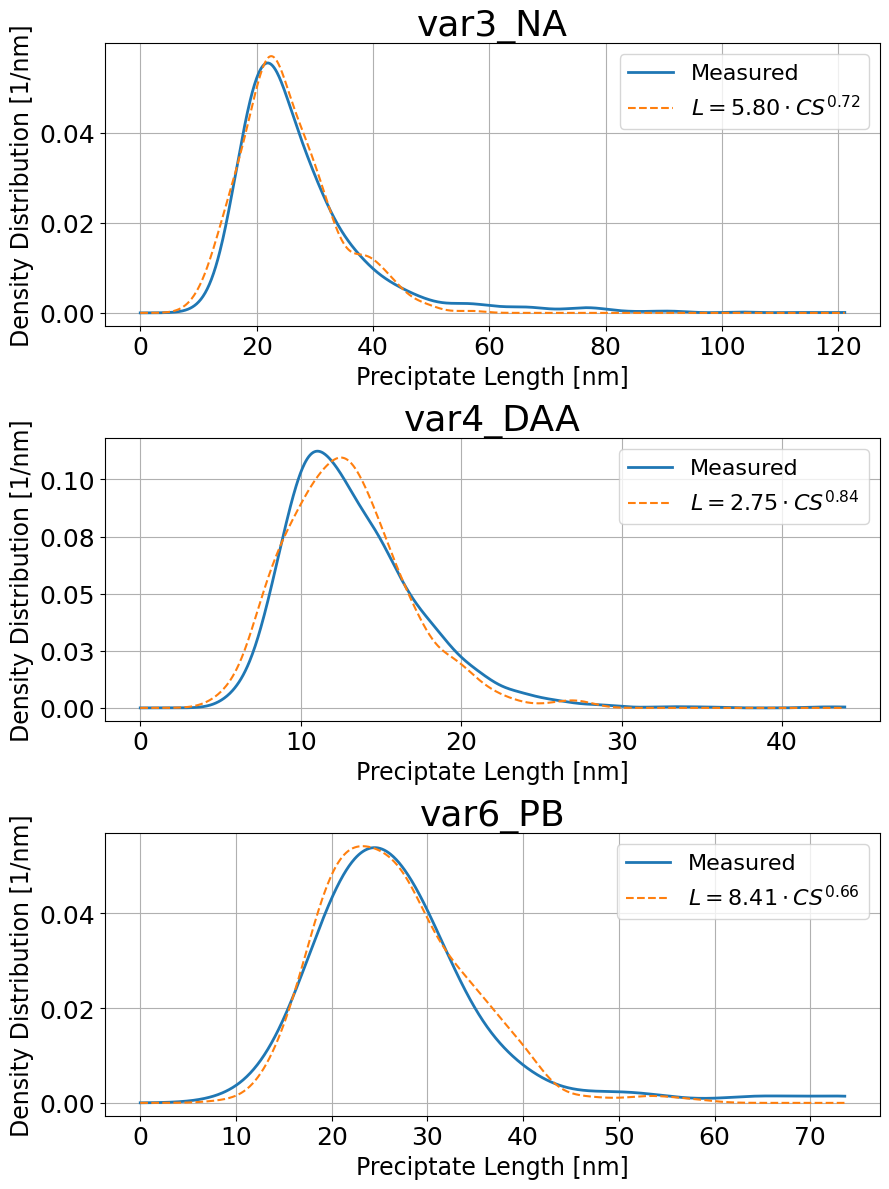

var3_NA: c = 5.80, alpha = 0.72
var4_DAA: c = 2.75, alpha = 0.84
var6_PB: c = 8.41, alpha = 0.66


In [ ]:

def predict_powerlaw(params, cross_sections):
    c, alpha = params
    return c * (cross_sections ** alpha)

def kde_distance_powerlaw(params, cross_sections, kde_actual, x_vals):
    predicted = predict_powerlaw(params, cross_sections)
    kde_pred = gaussian_kde(predicted)
    return np.mean((kde_actual(x_vals) - kde_pred(x_vals))**2)

def fit_and_plot(ax, alloy_name):
  
    df_cross = pd.read_csv(f'{alloy_name}_statistics_cross.csv')
    df_len = pd.read_csv(f'{alloy_name}_statistics_length.csv')
    cross_sections = df_cross['Cross section [nm^2]'].dropna().values
    lengths = df_len['Length [nm]'].dropna().values

   
    kde_actual = gaussian_kde(lengths)

    x_vals = np.linspace(0, lengths.max(), 1000)

    bounds = [(1, 20), (0.1, 1.5)]  # c, alpha
    result = differential_evolution(kde_distance_powerlaw, bounds, args=(cross_sections, kde_actual, x_vals))
    best_c, best_alpha = result.x

    predicted = predict_powerlaw([best_c, best_alpha], cross_sections)
    kde_pred = gaussian_kde(predicted)

    ax.plot(x_vals, kde_actual(x_vals), label="Measured", linewidth=2)
    ax.plot(x_vals, kde_pred(x_vals), 
            label=f"$L = {best_c:.2f} \\cdot CS^{{{best_alpha:.2f}}}$", linestyle='--')
    ax.set_title(alloy_name, fontsize = 26)
    ax.set_ylabel("Density Distribution [1/nm]", fontsize = 17)
    ax.set_xlabel("Preciptate Length [nm]", fontsize = 17)
    from matplotlib.ticker import FormatStrFormatter
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.tick_params(axis='both', labelsize=18)
    ax.grid(True)
    ax.legend(fontsize=16)
    return best_c, best_alpha


alloy_names = ['var3_NA', 'var4_DAA', 'var6_PB']

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(9, 12))  # You can increase height a bit

results = {}
for ax, name in zip(axes, alloy_names):
    c, alpha = fit_and_plot(ax, name)
    results[name] = (c, alpha)

plt.tight_layout()
plt.savefig("kde_fits_alloys.png", dpi=300)
plt.show()

for name, (c, alpha) in results.items():
    print(f"{name}: c = {c:.2f}, alpha = {alpha:.2f}")
